In [15]:
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import copy
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
results_df_2 = pd.read_csv('results_df_2.csv')

In [17]:
from matplotlib.pyplot import hist

(array([22., 27., 28., 26., 21., 13., 10.,  3.,  0.,  6.]),
 array([ 3. ,  7.2, 11.4, 15.6, 19.8, 24. , 28.2, 32.4, 36.6, 40.8, 45. ]),
 <a list of 10 Patch objects>)

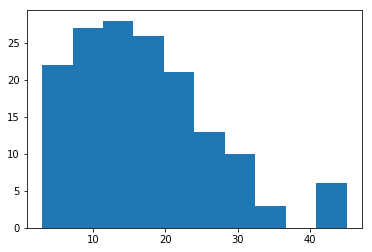

In [18]:
hist(results_df_2["k"])

(array([150.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   5.]),
 array([2.0000000e+00, 3.6288180e+05, 7.2576160e+05, 1.0886414e+06,
        1.4515212e+06, 1.8144010e+06, 2.1772808e+06, 2.5401606e+06,
        2.9030404e+06, 3.2659202e+06, 3.6288000e+06]),
 <a list of 10 Patch objects>)

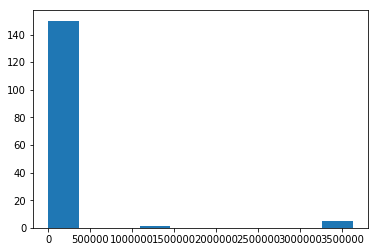

In [19]:
hist(results_df_2["p"])

In [20]:
from scipy.stats import kendalltau
kendalltau(results_df_2["k"],results_df_2["metric_mean"])

KendalltauResult(correlation=-0.1949356941316768, pvalue=0.0004858100598101006)

In [21]:
kendalltau(results_df_2["p"],results_df_2["metric_mean"])

KendalltauResult(correlation=-0.22310187962494898, pvalue=5.25734379191586e-05)

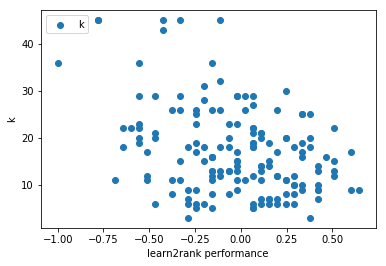

In [26]:
import matplotlib.pyplot as plt
import numpy as np



plt.scatter(results_df_2["metric_mean"], results_df_2["k"])
plt.xlabel("learn2rank performance")
plt.ylabel("k")
plt.legend(loc='upper left')
plt.show()

In [7]:
import sys
sys.path.insert(0,"/local/rankability_toolbox")

PATH_TO_RANKLIB='/local/ranklib'

In [8]:
import pyrankability

In [9]:
import pyltr

In [10]:
with open('MQ2008-list/Fold1/train.txt') as trainfile, \
        open('MQ2008-list/Fold1/vali.txt') as valifile, \
        open('MQ2008-list/Fold1/test.txt') as evalfile:
    TX, Ty, Tqids, Tdids = pyltr.data.letor.read_dataset(trainfile)
    VX, Vy, Vqids, Vdids = pyltr.data.letor.read_dataset(valifile)
    EX, Ey, Eqids, Edids = pyltr.data.letor.read_dataset(evalfile)

In [11]:
def subset_max_rank(X,y,qids,dids,max_rank = 10):
    keep_inxs = np.where(y<=max_rank)[0]
    X = X[keep_inxs,:]
    y = y[keep_inxs]
    qids = qids[keep_inxs]
    dids = dids[keep_inxs]
    return X,y,qids,dids


In [12]:
TX10,Ty10,Tqids10,Tdids10 = subset_max_rank(TX,Ty,Tqids,Tdids)
VX10,Vy10,Vqids10,Vdids10 = subset_max_rank(VX,Vy,Vqids,Vdids)
EX10,Ey10,Eqids10,Edids10 = subset_max_rank(EX,Ey,Eqids,Edids)

In [13]:
TX10.shape

(4710, 46)

In [14]:
metric = pyltr.metrics.KendallTau()

# Only needed if you want to perform validation (early stopping & trimming)
monitor = pyltr.models.monitors.ValidationMonitor(
    VX10, Vy10, Vqids10, metric=metric, stop_after=250)

model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=1000,
    learning_rate=0.01,
    max_features=0.5,
    query_subsample=0.5,
    max_leaf_nodes=10,
    min_samples_leaf=64,
    verbose=1
)

model.fit(TX10, Ty10, Tqids10, monitor=monitor)

 Iter  Train score  OOB Improve    Remaining                           Monitor Output 
    1      -0.3974       0.4751       40.91m      C:     -0.5281 B:     -0.5281 S:  0
    2      -0.3604       0.0704       41.24m      C:     -0.4474 B:     -0.4474 S:  0
    3      -0.0493       0.2484       40.75m      C:     -0.2660 B:     -0.2660 S:  0
    4      -0.0094       0.0433       40.49m      C:     -0.1824 B:     -0.1824 S:  0
    5       0.0200       0.0094       40.38m      C:     -0.1587 B:     -0.1587 S:  0
    6       0.0500      -0.0024       40.32m      C:     -0.1451 B:     -0.1451 S:  0
    7       0.0355       0.0034       40.36m      C:     -0.1507 B:     -0.1451 S:  1
    8       0.0948      -0.0055       40.23m      C:     -0.1233 B:     -0.1233 S:  0
    9       0.0530      -0.0019       40.03m      C:     -0.1071 B:     -0.1071 S:  0
   10       0.0790      -0.0096       39.89m      C:     -0.0987 B:     -0.0987 S:  0
   15       0.1102      -0.0072       39.61m      C: 

In [15]:
joblib.dump(model,"model.joblib.z")

['model.joblib.z']

In [16]:
def predict_process(model,metric,X,y,qids,dids):
    pred = model.predict(X)
    unique_qids = np.unique(qids)
    inxs_qid = {}
    rank_pred_qid = {}
    metric_mean_random_qid = {}
    metric_mean_qid = {}
    for qid in unique_qids:
        inxs_qid[qid] = np.where(qids == qid)[0]
        pred_qid = pred[inxs_qid[qid]]
        inxs_argsort = np.argsort(pred_qid)
        rank_pred_qid[qid] = np.zeros((len(inxs_qid[qid]),),dtype=int)
        rank_pred_qid[qid][inxs_argsort] = np.arange(rank_pred_qid[qid].shape[0],dtype=int)+1
        metric_mean_random_qid[qid] = metric.calc_mean_random(qids[inxs_qid[qid]], y[inxs_qid[qid]])
        metric_mean_qid[qid] = metric.calc_mean(qids[inxs_qid[qid]], y[inxs_qid[qid]], pred_qid)
    return rank_pred_qid, metric_mean_random_qid,metric_mean_qid

In [17]:
rank_pred_qid,metric_mean_random_qid,metric_mean_qid = predict_process(model,metric,EX10,Ey10,Eqids10,Edids10)

In [18]:
unique_qids = list(rank_pred_qid.keys())
results_df = pd.DataFrame({"qid": unique_qids,"metric_mean":[metric_mean_qid[k] for k in unique_qids],"metric_mean_random":[metric_mean_random_qid[k] for k in unique_qids]})

In [19]:
results_df.to_csv("results_df.csv",index=False)

In [1]:
results_df

NameError: name 'results_df' is not defined

In [20]:
np.savetxt('X.csv',EX10,"%.4f",delimiter=",")
np.savetxt('qids.csv',Eqids10,'%s',delimiter=',')

In [22]:
results_df.sort_values(by="metric_mean",ascending=False)

,qid,metric_mean,metric_mean_random
42,18662,0.644444,-1.200000e-02
135,19806,0.600000,-6.666667e-03
80,19140,0.600000,6.245005e-18
0,18219,0.511111,-2.088889e-02
130,19737,0.511111,-1.244444e-02
111,19487,0.511111,6.533333e-02
99,19383,0.511111,3.822222e-02
87,19236,0.466667,3.111111e-03
67,18996,0.422222,-1.955556e-02
14,18429,0.422222,2.355556e-02


In [31]:
def get_X(X,qids,qid):
    inxs = np.where(qids == qid)[0]
    return X[inxs,:]

In [44]:
sorted_qids = results_df.sort_values(by="metric_mean",ascending=True)['qid']

In [32]:
def construct_D1(Xqid,frac=0.3):
    n = Xqid.shape[0]
    m = Xqid.shape[1]
    D = np.zeros((n,n),dtype=int)
    C = np.zeros((n,n),dtype=int)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            C[i,j] = len(np.where(Xqid[i,:] > Xqid[j,:])[0])
    D[C > m*frac] = 1
    return D,C

In [33]:
from sklearn.feature_selection import VarianceThreshold

In [36]:
from dask.distributed import Client
from scipy.stats import zscore

client = Client("127.0.0.1:8786")

In [ ]:
ks = []
Ps = []
ps = []
i = 0
for qid in results_df["qid"]:
    var_thres = VarianceThreshold()
    Xqid = get_X(EX10,Eqids10,qid)
    var_thres.fit(Xqid)
    Xqid_norm = zscore(var_thres.transform(Xqid),axis=0)
    D,C = construct_D1(Xqid_norm,frac=0.4)
    np.savetxt("/dev/shm/D.csv",D,"%d",delimiter=",")
    k,P = pyrankability.pruning_paper_dask2.find_P("/dev/shm/D.csv",4,100,bilp_method="orig",prune_history=False,client=client)
    #k,P = pyrankability.bilp.bilp_orig(D)
    pyrankability.pruning_paper_dask3.find_P
    ks.append(k)
    Ps.append(P)
    ps.append(len(P))
    
results_df['k'] = ks
results_df['p'] = ps

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [ ]:
results_df.to_csv("results_df.csv",index=False)

In [43]:
ks,ps

([9, 17, 9, 14, 22, 12, 14, 16, 7, 8, 12, 10],
 [24, 512, 36, 180, 10080, 16, 30, 216, 10, 60, 168, 14])

In [2]:
results_df['k'] = ks
results_df['p'] = ps

NameError: name 'ks' is not defined

In [210]:
results_df

,qid,metric_mean,metric_mean_random,k,p
0,18219,0.466667,0.007556,14,1
1,18230,-0.155556,-0.006667,7,33
2,18328,0.422222,0.029333,9,30
3,18342,0.155556,0.027111,12,1
4,18356,0.022222,0.024889,13,1
5,18371,-0.155556,-0.014222,11,1
6,18377,-0.200000,0.010222,6,6
7,18378,-0.022222,-0.028000,11,1
8,18386,-0.600000,-0.019556,21,1
9,18400,-0.600000,-0.016889,22,1


In [188]:
var_thres = VarianceThreshold()
Xqid = get_X(EX10,Eqids10,'18356')
var_thres.fit(Xqid)
Xqid_norm = np.round(10*zscore(var_thres.transform(Xqid),axis=0))/10
D,C = construct_D1(Xqid_norm)
k,P = pyrankability.bilp.bilp_orig(D,max_solutions=100)
k,len(P)
D

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 0]])

In [132]:
from scipy.stats import zscore
from sklearn.feature_selection import VarianceThreshold
var_thres = VarianceThreshold()
var_thres.fit(Xqid)
Xqid_norm = zscore(var_thres.transform(Xqid),axis=0)
bilp_results = pyrankability.bilp.bilp_orig_opt_weights(Xqid_norm)

[[ 0.02 -0.02 -0.01  0.02  0.01  0.02 -0.02 -0.01  0.02  0.01  0.05  0.02
   0.02 -0.05  0.05  0.05 -0.07  0.04 -0.08 -0.01 -0.02 -0.02 -0.02 -0.05
  -0.05 -0.01 -0.04  0.03  0.04  0.02  0.04  0.03 -0.05  0.02 -0.05 -0.02
  -0.05  0.    0.09 -0.01]
 [-0.02 -0.02 -0.01 -0.05 -0.02 -0.02 -0.02 -0.01 -0.05 -0.02 -0.02 -0.03
  -0.03  0.04 -0.03 -0.02  0.03 -0.02  0.03 -0.01 -0.02 -0.02 -0.02  0.04
   0.03 -0.01  0.04 -0.05 -0.05 -0.05 -0.05 -0.04 -0.01 -0.03 -0.01  0.04
   0.04 -0.03 -0.02 -0.01]
 [-0.02 -0.02 -0.01 -0.05 -0.02 -0.02 -0.02 -0.01 -0.05 -0.02 -0.02 -0.02
  -0.03  0.04 -0.02 -0.02  0.03 -0.02  0.03 -0.01 -0.02 -0.02 -0.02  0.04
   0.03 -0.01  0.04 -0.05 -0.05 -0.05 -0.05 -0.04 -0.02 -0.03 -0.02  0.04
   0.04 -0.03 -0.02 -0.01]
 [-0.02 -0.02 -0.01 -0.05 -0.02 -0.02 -0.02 -0.01 -0.05 -0.02 -0.02 -0.02
  -0.03  0.05 -0.02 -0.02  0.03 -0.02  0.03 -0.01 -0.02 -0.02 -0.02  0.04
   0.03 -0.01  0.04 -0.05 -0.05 -0.05 -0.05 -0.04 -0.02 -0.03 -0.03  0.06
   0.05 -0.03 -0.02 -0.01]
 [-0

In [126]:
AP = bilp_results[0]


<gurobi.Model MIP instance rankability: 1065 constrs, 210 vars, Parameter changes: LogFile=gurobi.log, CSIdleTimeout=1800, OutputFlag=0>


## Construct the D matrix

In [ ]:
Tdocids = [did.split()[2] for did in Tdids] 

In [ ]:
Dmatrices = []
Dchanges = []
for qid in np.unique(Tqids):
    inxs = np.where(Tqids == qid)[0]
    docids = np.array(Tdocids)[inxs]
    D = np.zeros((len(docids),len(docids)),dtype=int)
    for i in range(len(docids)):
        for j in range(i+1,len(docids)):
            if Ty[i] != 0 and Ty[j] != 0:
                D[j,i] = 1
                D[i,j] = 1
                #D[i,j] = Ty[i]*1./Ty[j]
                #D[j,i] = Ty[j]*1./Ty[i]
            elif Ty[i] > Ty[j]:
                D[i,j] = 1
                #D[i,j] = Ty[i]
            elif Ty[j] > Ty[i]:
                D[j,i] = 1
                #D[j,i] = Ty[j]
    #np.round(10*D).astype(int)
    Dmatrices.append(D)
    Dtilde, changes, output = pyrankability.improve.greedy(D,1,verbose=False)
    Dchanges.append(changes)

In [7]:
Ty_norm = Ty/np.max(Ty)

In [8]:
np.min(Ty_norm)

0.0005461496450027307

In [ ]:
num_qids_to_include=20


unique_qids = np.unique(Tqids)
qids_inxs = np.random.choice(len(unique_qids), num_qids_to_include)
inxs_to_add = []
for qid in unique_qids[qids_inxs]:
    inxs_to_add += list(np.where(Tqids == qid)[0])
print(len(inxs_to_add))

TX_new = TX[inxs_to_add,:]
Ty_new = Ty[inxs_to_add]
Tqids_new = Tqids[inxs_to_add]
Tdids_new = Tdids[inxs_to_add]

In [22]:
import matplotlib.pyplot as plt

pd.DataFrame(TX).corr()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1.000000,-0.021351,-0.104887,-0.044510,0.999889,NaN,NaN,NaN,NaN,NaN,...,0.016779,0.094613,0.177441,0.154709,-0.044088,-0.067130,NaN,-0.019735,-0.023190,-0.035744
1,-0.021351,1.000000,0.302179,0.142278,-0.014966,NaN,NaN,NaN,NaN,NaN,...,0.207284,0.184504,0.158369,0.156879,-0.043868,-0.005267,NaN,0.074313,0.086666,0.032813
2,-0.104887,0.302179,1.000000,0.181569,-0.098711,NaN,NaN,NaN,NaN,NaN,...,0.293336,0.253959,0.174522,0.207752,0.006811,-0.047950,NaN,0.004930,0.018810,0.038692
3,-0.044510,0.142278,0.181569,1.000000,-0.039828,NaN,NaN,NaN,NaN,NaN,...,0.220213,0.181661,0.131890,0.148921,0.090902,0.220719,NaN,-0.004739,0.000899,-0.010234
4,0.999889,-0.014966,-0.098711,-0.039828,1.000000,NaN,NaN,NaN,NaN,NaN,...,0.019969,0.097030,0.179262,0.156817,-0.043804,-0.066301,NaN,-0.019222,-0.022533,-0.035633
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
pyltr.models.

(540679, 46)

In [26]:

#metric = pyltr.metrics.NDCG(k=10)

metric = pyltr.metrics.KendallTau()

# Only needed if you want to perform validation (early stopping & trimming)
monitor = pyltr.models.monitors.ValidationMonitor(
    VX[:10000,:], Vy[:10000], Vqids[:10000], metric=metric, stop_after=250)

model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=2,
    learning_rate=0.5,
    max_features=0.5,
    query_subsample=0.5,
    max_leaf_nodes=10,
    min_samples_leaf=64,
    verbose=1
)

model.fit(TX[:1000,:], Ty_norm[:1000], Tqids[:1000], monitor=monitor)

Epred = model.predict(EX)
print('Random ranking:', metric.calc_mean_random(Eqids, Ey))
print('Our model:', metric.calc_mean(Eqids, Ey, Epred))

 Iter  Train score  OOB Improve    Remaining                           Monitor Output 


KeyboardInterrupt: 

In [ ]:
Ey

## Now run the code that figures out what to select


In [ ]:
import joblib
results = joblib.load('results.joblib.z')

In [ ]:
def extract_did(did):
    return did.split(" ")[2]

In [ ]:
counts = {}
for qid in results.keys():
    i,j,action = results[qid]['changes'][0]
    inxs_i = results[qid]['inxs'][i]
    inxs_j = results[qid]['inxs'][j]
    did_i = extract_did(Tdids[inxs_i])
    did_j = extract_did(Tdids[inxs_j])
    if did_i not in counts:
        counts[did_i] = 0
    if did_j not in counts:
        counts[did_j] = 0
    counts[did_i]+=1
    counts[did_j]+=1

In [ ]:
counts_df = pd.DataFrame(list(counts.items()),columns=["docid","count"])

In [ ]:
counts_df

In [ ]:
counts_df.sort_values(by="count",ascending=False)

In [ ]:
threshold=1
inxs = np.where(counts_df["count"] >= threshold)[0]
n_add = len(inxs)

In [ ]:
Edocids = [extract_did(did) for did in Edids]

In [ ]:
counts_e_df = pd.DataFrame(list(dict(Counter(Edocids)).items()),columns=["docid","count"])

In [ ]:
Edocids

In [ ]:
counts_df["docid"]

In [ ]:
"GX000-08-9442355" in counts_df["docid"].values # GX000-00-0000000

In [ ]:
counts_e_df["include"] = 0

In [ ]:
for i,docid in enumerate(counts_df["docid"].values):
    inx = np.where(counts_e_df["docid"] == docid)[0]
    if len(inx) > 0:
        counts_e_df["include"].iloc[inx] = 1

In [ ]:
counts_e_df["qid"] = 0

In [ ]:
unique_Eqids = np.unique(Eqids)
qcounts = []
for qid in unique_Eqids:
    inxs = np.where(Eqids==qid)[0]
    qid_docs = np.array(Edocids)[inxs]
    c = 0
    for docid in qid_docs:
        if docid in counts.keys():
            c += counts[docid]
    qcounts.append(c)

In [ ]:
picking_qids = pd.DataFrame({"count":qcounts,"qid": unique_Eqids})

In [ ]:
top = picking_qids.sort_values(by="count",ascending=False).iloc[0:10,:]

In [ ]:
inxs_to_add = []
for qid in top["qid"]:
    print(qid)
    inxs_to_add += list(np.where(Eqids == qid)[0])

In [ ]:
TX_new = np.vstack((TX,EX[inxs_to_add,:]))
Ty_new = np.array(list(Ty)+list(Ey[inxs_to_add]))
Tqids_new = np.array(list(Tqids)+list(Eqids[inxs_to_add]))
Tdids_new = np.array(list(Tdids)+list(Edids[inxs_to_add]))

In [ ]:
metric = pyltr.metrics.NDCG(k=10)

# Only needed if you want to perform validation (early stopping & trimming)
monitor = pyltr.models.monitors.ValidationMonitor(
    VX, Vy, Vqids, metric=metric, stop_after=250)

model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=1000,
    learning_rate=0.02,
    max_features=0.5,
    query_subsample=0.5,
    max_leaf_nodes=10,
    min_samples_leaf=64,
    verbose=1,
)

model.fit(TX_new, Ty_new, Tqids_new, monitor=monitor)

In [ ]:
EX_new = np.delete(EX,inxs_to_add,axis=0)
Eqids_new = np.delete(Eqids,inxs_to_add)
Ey_new = np.delete(Ey,inxs_to_add)
Epred = model.predict(EX_new)
print('Random ranking:', metric.calc_mean_random(Eqids_new, Ey_new))
print('Our model:', metric.calc_mean(Eqids_new, Ey_new, Epred))

In [ ]:
EX_new.shape,EX.shape,Eqids.shape,Eqids_new.shape,Ey_new.shape

In [ ]:
counts_e_df.sort_values(by="count",ascending=False)

In [ ]:
new_Ty = Ey[inxs]

In [ ]:
from collections import Counter
results = dict(Counter(Tdocids))
np.sort(list(results.values()))

In [ ]:


from numpy import ix_
import numpy as np

In [ ]:
import pyrankability

In [ ]:
changes

In [ ]:
if D.shape[0] <= 8: # Only solve small problems
    search = pyrankability.exact.ExhaustiveSearch(Dsmall)
    search.find_P()

    print(pyrankability.common.as_json(search.k,search.P,{}))

    p = len(search.P)
    k = search.k

In [ ]:
def greedy(D,l):
    D = np.copy(D) # Leave the original untouched
    for niter in range(l):
        n=D.shape[0]
        
        k,P,X,Y,k2 = pyrankability.lp.lp(D)

        mult = 100
        X = np.round(X*mult)/mult
        Y = np.round(Y*mult)/mult

        T0 = np.zeros((n,n))
        T1 = np.zeros((n,n))
        inxs = np.where(D + D.transpose() == 0)
        T0[inxs] = 1
        inxs = np.where(D + D.transpose() == 2)
        T1[inxs] = 1
        T0[np.arange(n),np.arange(n)]= 0
        T1[np.arange(n),np.arange(n)] = 0

        DOM = D + X - Y

        Madd=T0*DOM # note: DOM = P_> in paper
        M1 = Madd # Copy Madd into M, % Madd identifies values >0 in P_> that have 0-tied values in D
        M1[Madd<=0] = np.nan # Set anything <= 0 to NaN
        min_inx = np.nanargmin(M1) # Find min value and index
        bestlinktoadd_i, bestlinktoadd_j = np.unravel_index(min_inx,M1.shape) # adding (i,j) link associated with
        # smallest nonzero value in Madd is likely to produce greatest improvement in rankability
        minMadd = M1[bestlinktoadd_i, bestlinktoadd_j]

        Mdelete=T1*DOM # note: DOM = P_> in paper
        Mdelete=Mdelete*(Mdelete<1) # Mdelete identifies values <1 in P_> that have 1-tied values in D
        bestlinktodelete_i, bestlinktodelete_j=np.unravel_index(np.nanargmax(Mdelete), Mdelete.shape) # deleting (i,j) link associated with
        # largest non-unit (less than 1) value in Mdelete is likely to produce greatest improvement in rankability
        maxMdelete = Mdelete[bestlinktodelete_i, bestlinktodelete_j]

        # This next section modifies D to create Dtilde
        Dtilde = np.copy(D) # initialize Dtilde
        # choose whether to add or remove a link depending on which will have the biggest
        # impact on reducing the size of the set P
        # PAUL: Or if we only want to do link addition, you don't need to form
        # Mdelete and find the largest non-unit value in it. And vice versa, if
        # only link removal is desired, don't form Madd.
        if (1-minMadd)>maxMdelete and p>=2:
            formatSpec = 'The best one-link way to improve rankability is by adding a link from %d to %d.\nThis one modification removes about %.10f percent of the rankings in P.'%(bestlinktoadd_i,bestlinktoadd_j,(1-minMadd)*100)
            print(formatSpec)
            Dtilde[bestlinktoadd_i,bestlinktoadd_j]=1 # adds this link, creating one-mod Dtilde
        elif 1-minMadd<maxMdelete and p>=2:
            formatSpec = 'The best one-link way to improve rankability is by deleting the link from %d to %d.\nThis one modification removes about %.10f percent of the rankings in P.' % (bestlinktodelete_i,bestlinktodelete_j,maxMdelete*100)
            print(formatSpec)
            Dtilde[bestlinktodelete_i,bestlinktodelete_j] = 0 # removes this link, creating one-mod Dtilde
            
        D = Dtilde

In [ ]:
Dtilde = greedy(D,1)

In [ ]:
search = pyrankability.exact.ExhaustiveSearch(Dtilde)
search.find_P()

print(pyrankability.common.as_json(search.k,search.P,{}))

In [ ]:
bestlinktoadd_i, bestlinktoadd_j

In [ ]:


    % Form modification matrices Madd (M_+) and Mdelete (M_-), which are used
    % to determine which link modification most improves rankability


    Mdelete=T1.*DOM; % note: DOM = P_> in paper
    Mdelete=Mdelete.*(Mdelete<1); % Mdelete identifies values <1 in P_> that have 1-tied values in D
    maxMdelete=max(max(Mdelete));
    [bestlinktodelete_i bestlinktodelete_j]=find(Mdelete==maxMdelete);  % deleting (i,j) link associated with
    % largest non-unit (less than 1) value in Mdelete is likely to produce greatest improvement in rankability


    % This next section modifies D to create Dtilde
    Dtilde=D; % initialize Dtilde
    % choose whether to add or remove a link depending on which will have the biggest
    % impact on reducing the size of the set P
    % PAUL: Or if we only want to do link addition, you don't need to form
    % Mdelete and find the largest non-unit value in it. And vice versa, if
    % only link removal is desired, don't form Madd.
    if 1-minMadd>maxMdelete & p>=2
        formatSpec = 'The best one-link way to improve rankability is by adding a link from %4.f to %4.f.\nThis one modification removes about %2.f percent of the rankings in P.';
        fprintf(formatSpec,bestlinktoadd_i(1),bestlinktoadd_j(1),(1-minMadd)*100)
        Dtilde(bestlinktoadd_i(1),bestlinktoadd_j(1))=1; % adds this link, creating one-mod Dtilde
    elseif 1-minMadd<maxMdelete & p>=2
        formatSpec = 'The best one-link way to improve rankability is by deleting the link from %4.f to %4.f.\nThis one modification removes about %2.f percent of the rankings in P.';
        fprintf(formatSpec,bestlinktodelete_i(1),bestlinktodelete_j(1),maxMdelete*100)
        Dtilde(bestlinktodelete_i(1),bestlinktodelete_j(1))=0; % removes this link, creating one-mod Dtilde
    end


    % set D=Dtilde and repeat until l link modifications have been made or
    % p=1
    D=Dtilde;